In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex']=True
import scipy
from scipy import interpolate
import scipy.integrate as si
import scipy.special as spec

import sys, platform, os
import camb
from camb import model, initialpower
from pylab import imshow,cm
from matplotlib.colors import LogNorm

import time

In [2]:
Omega_bh2 = 0.02230; Omega_bh21s = 0.00014

Omega_ch2 = 0.1188 ; Omega_ch21s = 0.0010

h = 0.6774; h1s = 0.0046

Omega_m = (Omega_ch2+Omega_bh2)/h**2

Omega_l = 1.-Omega_m

A_s1010 = 2.142*10.; A_s10101s = 0.049*10

n_s = 0.9667; n_s1s = 0.0040

sigma_8 = 0.8159; sigma_81s = 0.0086

H0 = 100.; c = 3e5; 

M_nu = 0.06; 

# Neff = 3.04; Neff1s=0.33

print Omega_m, Omega_l, h, np.log(A_s1010), A_s1010/1e10

0.307493988068 0.692506011932 0.6774 3.06432506502 2.142e-09


In [3]:
#we use this function to compute the comoving distance to a given redshift
def func(y,x,Omega_m,Omega_L):
    return [1.0/np.sqrt(Omega_m*(1.0+x)**3+Omega_L)]
##############################################################################

##############################################################################
#This functions computes the comoving distance to redshift z, in Mpc/h
#As input it needs z, Omega_m and Omega_L. It assumes a flat cosmology
def comoving_distance(z,Omega_m,Omega_L):
    H0=100.0 #km/s/(Mpc/h)
    c=3e5    #km/s
    #compute the comoving distance to redshift z
    yinit=[0.0]
    z_limits=[0.0,z]
    I=si.odeint(func,yinit,z_limits,args=(Omega_m,Omega_L),
                rtol=1e-8,atol=1e-8,mxstep=100000,h0=1e-6)[1][0]
    r=c/H0*I
    return r


z = np.linspace(0,6,1000)
Dc = np.zeros(z.size)
for i,r in enumerate(z):
    Dc[i] = comoving_distance(r,Omega_m,Omega_l)    
Dcom = scipy.interpolate.interp1d(z, Dc, kind='linear')

# Here we also define E(z) since we will need it to compute the comoving volumes:
def E(z,Omega_m,Omega_l):
    return np.sqrt(Omega_l + Omega_m*(1+z)**3)

# Here we compute the linear growth factor using Pacos code and interpolate it:
##############################################################################
def func_lgf(y,x,Omega_m,Omega_L):
    #print x, 1.0/(x**3 * (np.sqrt(Omega_m/x**3 + Omega_L))**3)
    return 1.0/(x*np.sqrt(Omega_m/x**3 + Omega_L))**3

#This function computes the linear growth factor. See Eq. 1 of 0006089
#Notice that in that formula H(a) = (Omega_m/a^3+Omega_L)^1/2 and that the 
#growth is D(a), not g(a). We normalize it such as D(a=1)=1
def linear_growth_factor(z,Omega_m,Omega_L):
    
    # compute linear growth factor at z and z=0
    yinit = [0.0];  a_limits = [1e-30, 1.0/(1.0+z), 1.0/(1.0+0.0)]
    I = si.odeint(func_lgf,yinit,a_limits,args=(Omega_m,Omega_L),
                  rtol=1e-10,atol=1e-10,mxstep=100000,h0=1e-20)[1:]
    redshifts = np.array([ [z], [0.0] ])
    Ha = np.sqrt(Omega_m*(1.0+redshifts)**3 + Omega_L)
    D = (5.0*Omega_m/2.0)*Ha*I

    return D[0]/D[1]
##############################################################################

l = np.zeros(z.size)
for i,r in enumerate(z):
    l[i]=linear_growth_factor(r,Omega_m,Omega_l)
lgf = scipy.interpolate.interp1d(z, l, kind='quadratic', bounds_error=False, fill_value=0.)

In [4]:
def kPk(z,Mnu):
    pars = camb.CAMBparams()
    pars.set_accuracy(AccuracyBoost=4)
    pars.set_cosmology(H0=h*100., ombh2=Omega_bh2, omch2=Omega_ch2-Mnu/94.07/h**2*(3.04/3.)**0.75*h**2, omk=0.0,\
                      num_massive_neutrinos=3, mnu=Mnu, nnu=3.04, YHe=0.24, meffsterile=0, \
                       standard_neutrino_neff=3.04, TCMB=2.725)
    pars.set_dark_energy() #re-set defaults
    pars.InitPower.set_params(As=A_s1010*1e-10,ns=n_s, r=0)
    #Not non-linear corrections couples to smaller scales than you want
    pars.set_matter_power(redshifts=z, kmax=1.0, k_per_logint=30)
    #Linear spectra
    pars.NonLinear = model.NonLinear_none
    results0 = camb.get_results(pars)
    print pars
    # print results.
    kh0, z0, pkh0 = results0.get_matter_power_spectrum(minkh= 1e-4, maxkh=1e2, npoints=500)
    return [kh0, pkh0]

if not os.path.exists("./Power_spectra/Fiducial"):
    k, Pk = kPk(np.arange(0.,5.2,0.1),M_nu)
    Pkz0 = scipy.interpolate.interp1d(k, Pk[0])
    Pkz  = scipy.interpolate.interp1d(np.arange(0.,5.2,0.1),Pk,axis=0)
    os.makedirs("./Power_spectra/Fiducial")
    for i in np.arange(0.,5.2,0.1):
        np.savetxt('./Power_spectra/Fiducial/k_Pk_fiducial_z_%0.1f.txt'%i, np.transpose([k,Pkz(i)]))
if os.path.exists("./Power_spectra/Fiducial"):
    Pk = np.zeros((np.size(np.arange(0.,5.2,0.1)),500))
    for i,zf in enumerate(np.arange(0.,5.2,0.1)):
        k, Pk[i,:] = np.loadtxt("./Power_spectra/Fiducial/k_Pk_fiducial_z_%0.1f.txt"%zf, unpack=True)
        Pkz0 = scipy.interpolate.interp1d(k, Pk[0])
        Pkz  = scipy.interpolate.interp1d(np.arange(0.,5.2,0.1),Pk,axis=0)

In [7]:
# Constants
pi=np.pi
delta_crit = 1.686
rho_crit   = 2.77536627e11 #h^2 Msun/Mpc^3

#Define a redshift array:
z_nu = np.arange(0,6,0.1)
path = './'
Mtable, nutable = np.loadtxt(path + "M_nu_tables/Planck_M_nu_%.2f.txt"%z_nu[0], unpack=True)
print "Mbins = ", Mtable.size, "Min Mass", np.log10(np.min(Mtable)), "Max Mass", np.log10(np.max(Mtable))

Mbins =  300 Min Mass 8.0 Max Mass 15.0


In [8]:
# Tinker halo bias 2010
def Tinker_halo_bias(nu):
    Delta=200.0
    y=np.log10(Delta)

    A=1.0+0.24*y*np.exp(-(4.0/y)**4);          a=0.44*y-0.88
    B=0.183;                                   b=1.5
    C=0.019+0.107*y+0.19*np.exp(-(4.0/y)**4);  c=2.4

    return 1.0-A*nu**a/(nu**a+delta_crit**a)+B*nu**b+C*nu**c

# Tinker 2010 halo mass function
def f_nu(nus,z):
    alpha  = 0.368
    beta0  = 0.589;       beta  = beta0*(1.0+z)**0.20
    gamma0 = 0.864;       gamma = gamma0*(1.0+z)**(-0.01)
    phi0   = -0.729;      phi   = phi0*(1.0+z)**(-0.08)
    eta0   = -0.243;      eta   = eta0*(1.0+z)**0.27

    fnu = alpha*(1.0+(beta*nus)**(-2.0*phi))*nus**(2.0*eta)*\
            np.exp(-gamma*nus**2/2.0)
    return fnu

In [9]:
Ms = Mtable[:]
nus = nutable[:]

In [12]:
Mmin = 5.33e12
M1   = 1.15e14
alp  = 1.27

def OmegaM(z):
    return (Omega_m*(1+z)**3/(1.-Omega_m + Omega_m*(1.+z)**3))

def rho_m(z):
    return rho_crit*OmegaM(z)

def Delta_v(z):
    _x = OmegaM(z)-1.
    return (18.*np.pi**2 + 82.*_x - 39.*_x**2)/(1. + _x)

def conc(z,M):
    return 9*(M/np.interp(1.,nus,Ms))**(-0.13)
    
def Rv(z,M):
    return (3.0*M/(4.0*np.pi*Delta_v(z)*rho_m(z)))**(1.0/3.0) 

def rs(z,M):
    _c = conc(z,M)
    return (3.0*M/(4.0*np.pi*_c**3*Delta_v(z)*rho_m(z)))**(1.0/3.0)     

def u_RM(z,r,M):
    _c = conc(z,M)
    _f = 1./(np.log(1.+_c)-_c/(1.+_c))
    return _f/(4.*np.pi)/(r*(r+rs(z,M))**2)

def deriv_ukm(y,x,z,k,M):
    kR=x*k
    uRM = u_RM(z,x,M)
    return [x**2*np.sin(kR)/kR*uRM]
    
def UkM(z,k,M):
    yinit = [0.0]
    R_limits = [1e-5, Rv(z,M)]
    I = si.odeint(deriv_ukm,yinit,R_limits,args=(z,k,M),\
                      rtol=1e-8,atol=1e-8,mxstep=100000)[1][0]*(4.0*np.pi)
    return I

ukmarray_new_c = np.zeros((k.size,20))
M_array = 10**np.linspace(8,15,20)
for im,mi in enumerate(M_array):
    for ik,ki in enumerate(k):
        ukmarray_new_c[ik,im] = UkM(0,ki,mi)

In [13]:
print M_array

[  1.00000000e+08   2.33572147e+08   5.45559478e+08   1.27427499e+09
   2.97635144e+09   6.95192796e+09   1.62377674e+10   3.79269019e+10
   8.85866790e+10   2.06913808e+11   4.83293024e+11   1.12883789e+12
   2.63665090e+12   6.15848211e+12   1.43844989e+13   3.35981829e+13
   7.84759970e+13   1.83298071e+14   4.28133240e+14   1.00000000e+15]


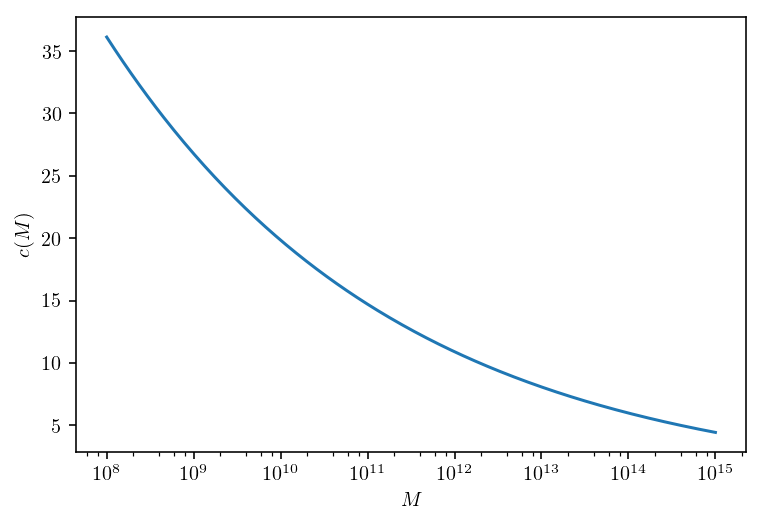

In [14]:
plt.semilogx(Ms,conc(0,Ms))
plt.xlabel('$M$')
plt.ylabel('$c(M)$')

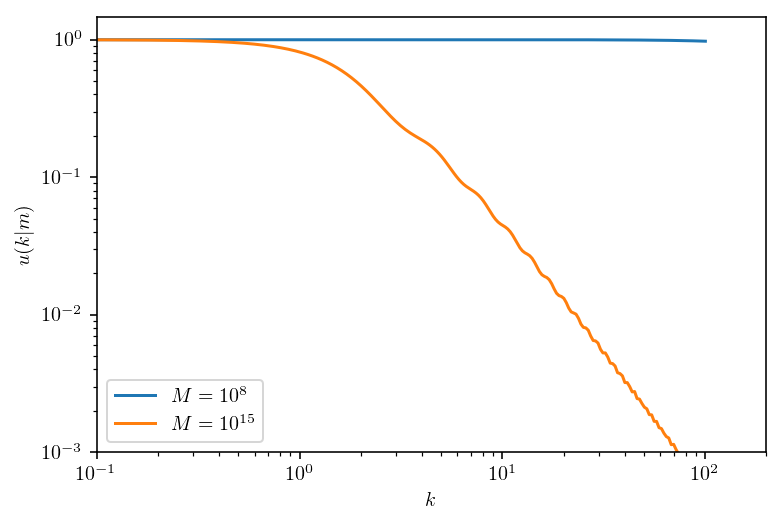

In [15]:
plt.loglog(k,ukmarray_new_c[:,0], label = '$M=10^{%.f}$'%np.log10(M_array[0]))
plt.loglog(k,ukmarray_new_c[:,-1], label = '$M=10^{%.f}$'%np.log10(M_array[-1]))
plt.xlim(1e-1)
plt.ylim(1e-3)
plt.xlabel('$k$')
plt.ylabel('$u(k|m)$')
plt.legend(loc=0)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in divide


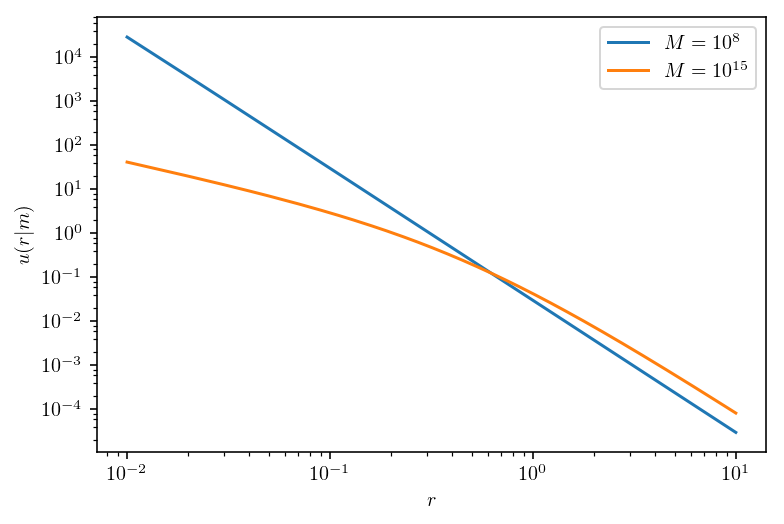

In [16]:
_rarray = np.linspace(0,10,1000)
plt.loglog(_rarray,u_RM(0.,_rarray,M_array[0]), label = '$M=10^{%.f}$'%np.log10(M_array[0]))
plt.loglog(_rarray,u_RM(0.,_rarray,M_array[-1]), label = '$M=10^{%.f}$'%np.log10(M_array[-1]))
plt.legend(loc=0)
plt.xlabel('$r$')
plt.ylabel('$u(r|m)$')

In [17]:
ukm_int_2 = scipy.interpolate.interp1d(k,ukmarray_new_c, axis=0)

In [18]:
def ncen(M,Mcut,sigmacen):
    return 0.5*spec.erfc(np.log(Mcut/M)/(np.sqrt(2.)*sigmacen))
def nsat(M,kappa,Mcut,M_1,alpha):
    toreturn = ((M-kappa*Mcut)/M_1)**alpha
    toreturn[np.isnan(toreturn)] = 0.
    toreturn[toreturn<0] = 0.
    return toreturn

5.38077946202e+12 2.30990829113e+13 4.08173863607e+13
12.7308451923 13.3635947377 13.6108451923
2.142126887e+13 1.80462750465e+14 3.39504232059e+14


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in power


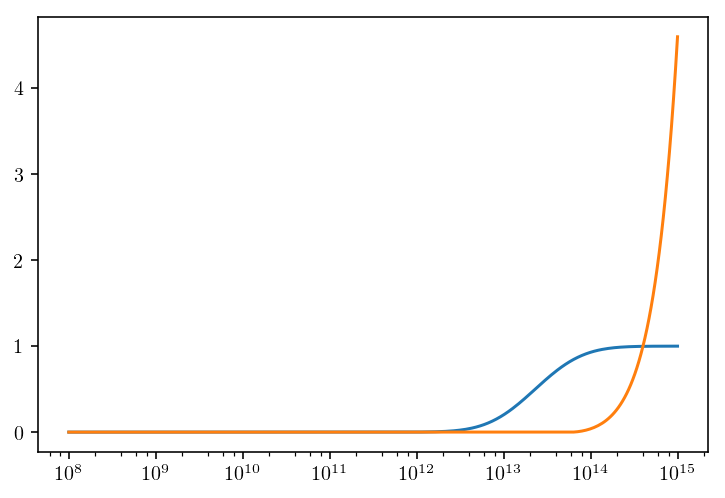

In [22]:
Mcutf_min = h*10**12.9; Mcutf_max = h*10**13.78
Mcutf = 0.5*(Mcutf_max+Mcutf_min)
M1f_min   = h*10**13.5; M1f_max   = h*10**14.7
M1f   = 0.5*(M1f_min+M1f_max)
sigmacenf= 1.; sigmacenf_min = 0.5; sigmacenf_max = 1.2
kappaf = 1.; kappaf_min = 0.5; kappaf_max = 1.5
alphaf = 1.; alphaf_min = 0.5; alphaf_max = 1.5

print Mcutf_min, Mcutf, Mcutf_max
print np.log10(Mcutf_min), np.log10(Mcutf), np.log10(Mcutf_max)
print M1f_min, M1f, M1f_max

plt.semilogx(Ms, ncen(Ms,Mcutf,sigmacenf))
plt.semilogx(Ms, nsat(Ms,kappaf_max,Mcutf_max,M1f_max,alphaf_max))

2.43153956601e-35
0.0


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in power


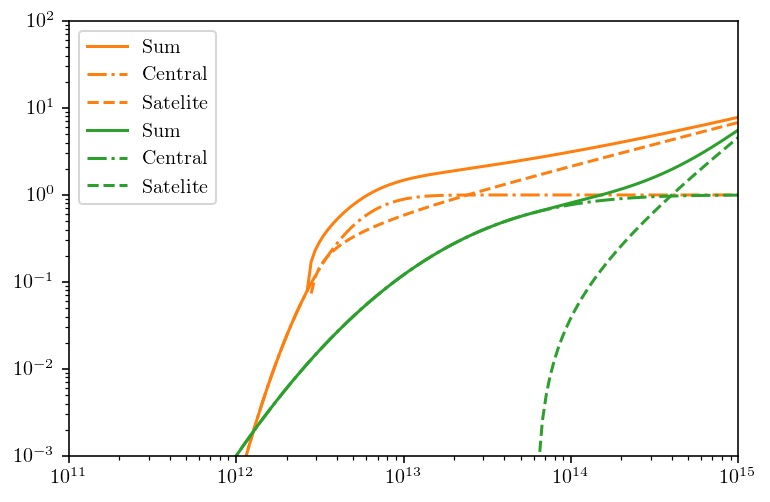

In [20]:
print np.min(ncen(Ms,Mcutf,sigmacenf))
print np.min(nsat(Ms,kappaf,Mcutf,M1f,alphaf))

plt.loglog(Ms,ncen(Ms,Mcutf_min,sigmacenf_min)+nsat(Ms,kappaf_min,Mcutf_min,M1f_min,alphaf_min), 'C1', label = '$\\mathrm{Sum}$')
plt.loglog(Ms,ncen(Ms,Mcutf_min,sigmacenf_min), 'C1-.', label = '$\\mathrm{Central}$')
plt.loglog(Ms,nsat(Ms,kappaf_min,Mcutf_min,M1f_min,alphaf_min), 'C1--', label = '$\\mathrm{Satelite}$')

plt.loglog(Ms,ncen(Ms,Mcutf_max,sigmacenf_max)+nsat(Ms,kappaf_max,Mcutf_max,M1f_max,alphaf_max), 'C2', label = '$\\mathrm{Sum}$')
plt.loglog(Ms,ncen(Ms,Mcutf_max,sigmacenf_max), 'C2-.', label = '$\\mathrm{Central}$')
plt.loglog(Ms,nsat(Ms,kappaf_max,Mcutf_max,M1f_max,alphaf_max), 'C2--', label = '$\\mathrm{Satelite}$')
plt.xlim(1e11,1e15)
plt.ylim(1e-3,1e2)
plt.legend(loc=0)

0.0


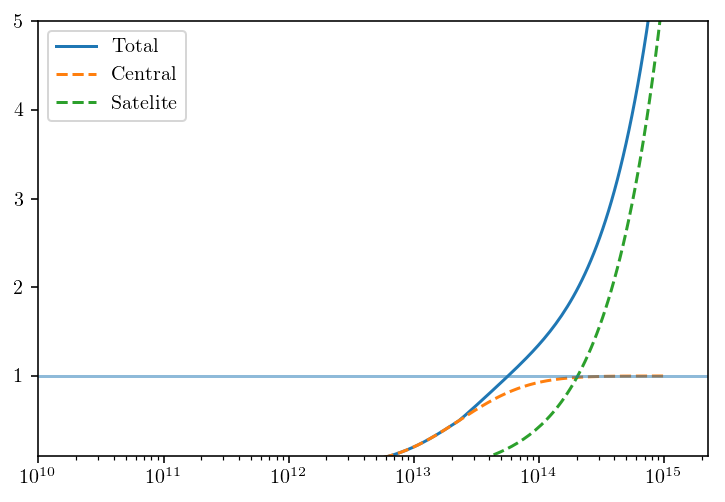

In [23]:
plt.semilogx(Ms,ncen(Ms,Mcutf,sigmacenf)+nsat(Ms,kappaf,Mcutf,M1f,alphaf), label = '$\\mathrm{Total}$')
plt.semilogx(Ms,ncen(Ms,Mcutf,sigmacenf), '--', label = '$\\mathrm{Central}$')
plt.semilogx(Ms,nsat(Ms,kappaf,Mcutf,M1f,alphaf), '--', label = '$\\mathrm{Satelite}$')
plt.xlim(1e10)
plt.ylim(1e-1,5)
plt.axhline(y=1, alpha = 0.5)
plt.legend(loc=0)

print np.min(nsat(Ms,kappaf,Mcutf,M1f,alphaf))

0.000402200045773


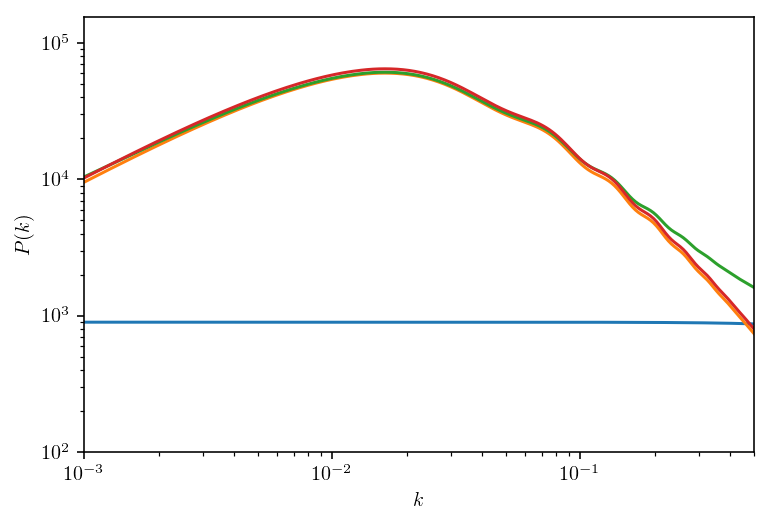

In [24]:
def nbarg_5p(z,Mcut,M1,sigmacen,kappa,alpha):
    return si.simps(f_nu(nus,0)*rho_m(0.)/Ms*(ncen(Ms,Mcut,sigmacen)+nsat(Ms,kappa,Mcut,M1,alpha)),nus)

def P1H_5p(_k,Mcut,M1,sigmacen,kappa,alpha):
    return si.simps(f_nu(nus,0)*rho_m(0.)/Ms/nbarg_5p(0,Mcut,M1,sigmacen,kappa,alpha)**2\
                    *(2.*ncen(Ms,Mcut,sigmacen)*nsat(Ms,kappa,Mcut,M1,alpha)*np.interp(Ms,M_array,ukm_int_2(_k))+\
                     nsat(Ms,kappa,Mcut,M1,alpha)**2*np.interp(Ms,M_array,ukm_int_2(_k))**2)\
                    ,nus)

def P2H_5p(_k,Mcut,M1,sigmacen,kappa,alpha):
    return (si.simps(f_nu(nus,0)*Tinker_halo_bias(nus)*rho_m(0.)/Ms/nbarg_5p(0,Mcut,M1,sigmacen,kappa,alpha)\
                    *(ncen(Ms,Mcut,sigmacen)+nsat(Ms,kappa,Mcut,M1,alpha)\
                    *np.interp(Ms,M_array,ukm_int_2(_k))),\
                     nus))**2*Pkz0(_k)

p1htest5p = np.zeros_like(k)
p2htest5p = np.zeros_like(k)

p1htest5p_Mcut_min = np.zeros_like(k)
p2htest5p_Mcut_min = np.zeros_like(k)
p1htest5p_Mcut_max = np.zeros_like(k)
p2htest5p_Mcut_max = np.zeros_like(k)

p1htest5p_M1_min = np.zeros_like(k)
p2htest5p_M1_min = np.zeros_like(k)
p1htest5p_M1_max = np.zeros_like(k)
p2htest5p_M1_max = np.zeros_like(k)

for ik,ki in enumerate(k):
    p1htest5p[ik] = P1H_5p(ki,Mcutf,M1f,sigmacenf,kappaf,alphaf)
    p2htest5p[ik] = P2H_5p(ki,Mcutf,M1f,sigmacenf,kappaf,alphaf)
    
    p1htest5p_Mcut_min[ik] = P1H_5p(ki,Mcutf_min,M1f,sigmacenf,kappaf,alphaf)
    p2htest5p_Mcut_min[ik] = P2H_5p(ki,Mcutf_min,M1f,sigmacenf,kappaf,alphaf)
    p1htest5p_Mcut_max[ik] = P1H_5p(ki,Mcutf_max,M1f,sigmacenf,kappaf,alphaf)
    p2htest5p_Mcut_max[ik] = P2H_5p(ki,Mcutf_max,M1f,sigmacenf,kappaf,alphaf)
    
    p1htest5p_M1_min[ik] = P1H_5p(ki,Mcutf,M1f_min,sigmacenf,kappaf,alphaf)
    p2htest5p_M1_min[ik] = P2H_5p(ki,Mcutf,M1f_min,sigmacenf,kappaf,alphaf)
    p1htest5p_M1_max[ik] = P1H_5p(ki,Mcutf,M1f_max,sigmacenf,kappaf,alphaf)
    p2htest5p_M1_max[ik] = P2H_5p(ki,Mcutf,M1f_max,sigmacenf,kappaf,alphaf)
    
plt.loglog(k,p1htest5p)
plt.loglog(k,p2htest5p)
plt.loglog(k,p1htest5p+p2htest5p)
plt.loglog(k,Pkz0(k)*1.6**2)
plt.xlim(1e-3,0.5)
plt.ylim(1e2)
plt.xlabel('$k$')
plt.ylabel('$P(k)$')

print nbarg_5p(0.,Mcutf,M1f,sigmacenf,kappaf,alphaf)

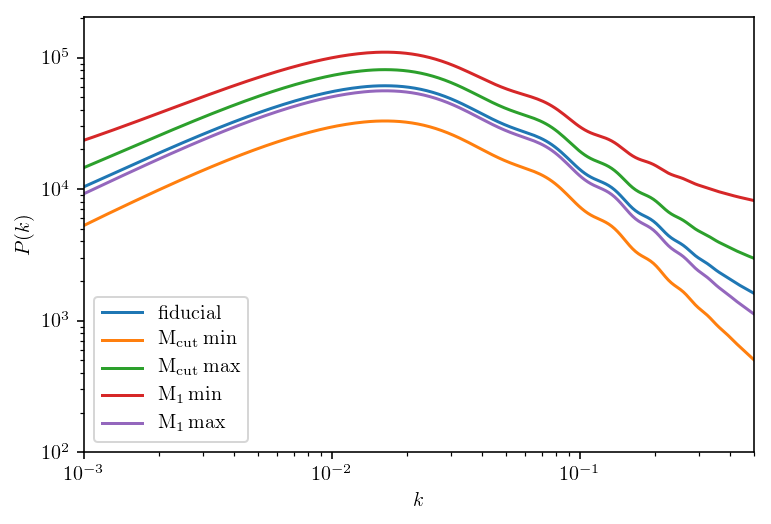

In [25]:
plt.loglog(k,p1htest5p+p2htest5p, label = '$\\mathrm{fiducial}$')

plt.loglog(k,p1htest5p_Mcut_min+p2htest5p_Mcut_min, label = '$\\mathrm{M_{cut}\,min}$')
plt.loglog(k,p1htest5p_Mcut_max+p2htest5p_Mcut_max, label = '$\\mathrm{M_{cut}\,max}$')

plt.loglog(k,p1htest5p_M1_min+p2htest5p_M1_min, label = '$\\mathrm{M_{1}\,min}$')
plt.loglog(k,p1htest5p_M1_max+p2htest5p_M1_max, label = '$\\mathrm{M_{1}\,max}$')

plt.xlim(1e-3,0.5)
plt.ylim(1e2)
plt.xlabel('$k$')
plt.ylabel('$P(k)$')
plt.legend(loc=0)

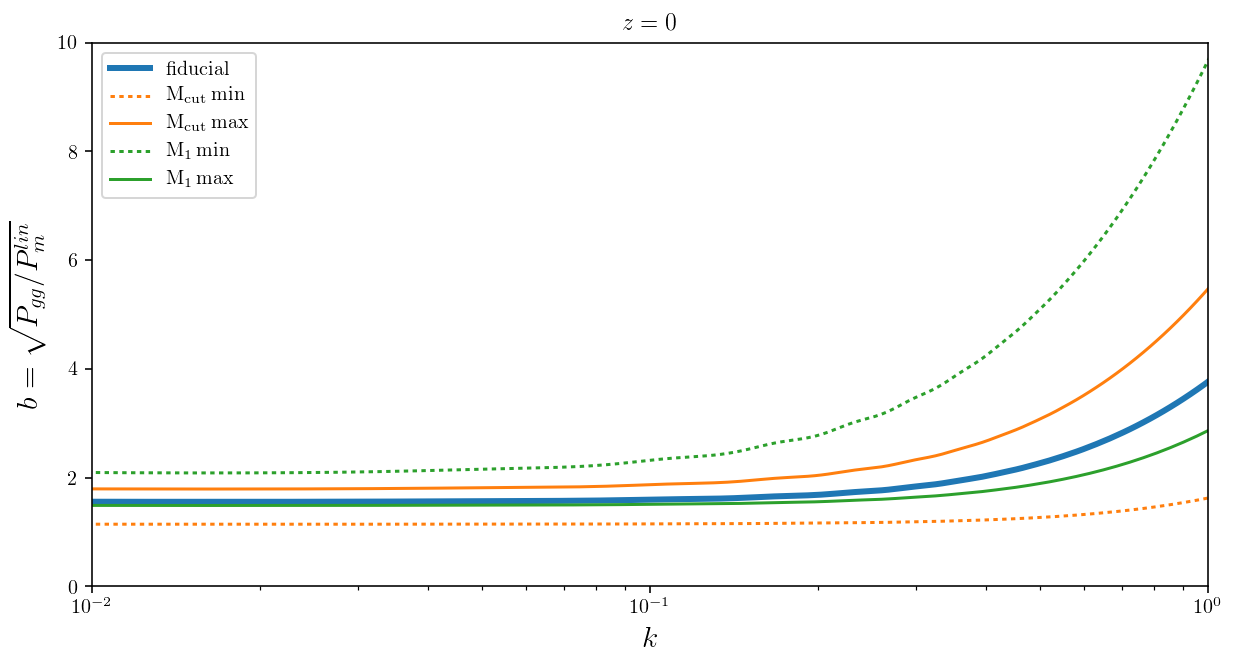

In [26]:
fig = plt.figure(figsize=(10,5))

plt.semilogx(k,np.sqrt((p1htest5p+p2htest5p)/Pkz0(k)), linewidth=3,label = '$\\mathrm{fiducial}$')

plt.semilogx(k, np.sqrt((p1htest5p_Mcut_min+p2htest5p_Mcut_min)/Pkz0(k)), 'C1:',label = '$\\mathrm{M_{cut}\,min}$')
plt.semilogx(k,np.sqrt((p1htest5p_Mcut_max+p2htest5p_Mcut_max)/Pkz0(k)), 'C1',label = '$\\mathrm{M_{cut}\,max}$')

plt.semilogx(k,np.sqrt((p1htest5p_M1_min+p2htest5p_M1_min)/Pkz0(k)), 'C2:',label = '$\\mathrm{M_{1}\,min}$')
plt.semilogx(k,np.sqrt((p1htest5p_M1_max+p2htest5p_M1_max)/Pkz0(k)), 'C2', label = '$\\mathrm{M_{1}\,max}$')

plt.xlim(1e-2,1)
plt.ylim(0,10)
plt.xlabel('$k$', fontsize=15)
plt.ylabel('$b=\sqrt{P_{gg}/P_m^{lin}}$', fontsize=15)
plt.title('$z=0$')
plt.legend(loc=0)